In [1]:
import numpy as np
import matplotlib.pyplot as plt

from imports.algorithm import gradient_tracking
from imports.loss import QuadraticFunction, TargetLocalizationLoss
from imports.utils import create_network_of_agents
from imports.plot import plot_scenario

## Quadratic function

In [2]:
NUM_AGENTS = 10
VARS_DIM = 2
SEED = 42

In [3]:
_, A = create_network_of_agents(
    NUM_AGENTS,
    "doubly-stochastic",
    connected = True,
    seed = SEED,
    doubly_stochastic_num_iter = 10000
)

In [4]:
rng = np.random.default_rng(SEED)
Q_list = [ np.diag( rng.uniform(size=VARS_DIM) ) for _ in range(NUM_AGENTS)] 
r_list = [ rng.normal(size=VARS_DIM) for _ in range(NUM_AGENTS) ]

quadratic_fns = [ QuadraticFunction(Q_list[i], r_list[i]) for i in range(NUM_AGENTS) ]

Q_all, r_all = np.sum(Q_list, axis=0), np.sum(r_list, axis=0)
optimal_quadratic_fn = QuadraticFunction(Q_all, r_all)
optimal_z = -np.linalg.inv(Q_all) @ r_all
optimal_cost = optimal_quadratic_fn(optimal_z)

z0 = rng.random(size=(NUM_AGENTS, VARS_DIM))

Cost: -0.7877809860966201 | Optimal: -0.787780986665408


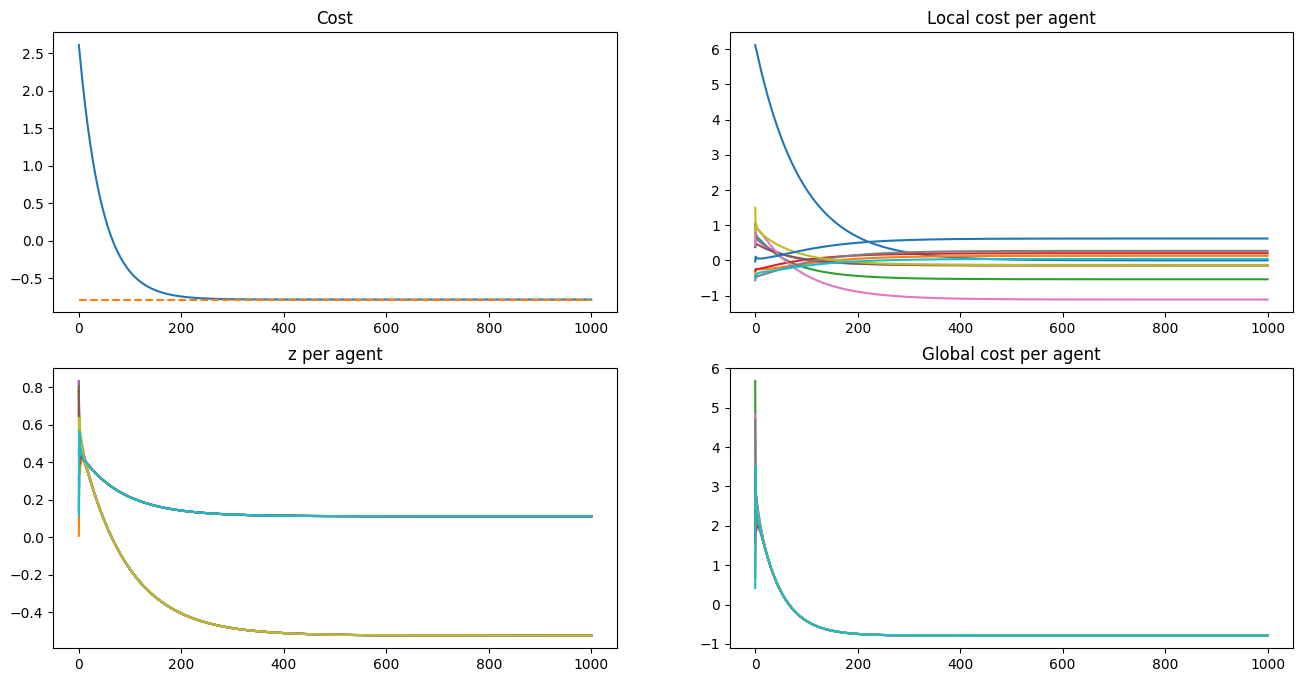

In [5]:
history_z = gradient_tracking(
    fn_list = quadratic_fns,
    z0 = z0.copy(),
    A = A,
    num_iters = 1000,
    alpha = 2e-2,
)


print(f"Cost: {optimal_quadratic_fn(history_z[-1].mean(axis=0))} | Optimal: {optimal_cost}")

plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.title("Cost")
plt.plot([ optimal_quadratic_fn(z.mean(axis=0)) for z in history_z ])
plt.plot([optimal_cost]*len(history_z), "--", label="Optimum")


plt.subplot(2, 2, 2)
plt.title("grad cost")
plt.plot([ np.linalg.norm(optimal_quadratic_fn.grad(z.mean(axis=0))) for z in history_z ])

plt.subplot(2, 2, 2)
plt.title("Local cost per agent")
for i in range(NUM_AGENTS):
    plt.plot([ quadratic_fns[i](z[i]) for z in history_z ], label=f"Cost agent {i}")

plt.subplot(2, 2, 3)
plt.title("z per agent")
for i in range(NUM_AGENTS):
    plt.plot([ z[i] for z in history_z ], label=f"z agent {i}")

plt.subplot(2, 2, 4)
plt.title("Global cost per agent")
for i in range(NUM_AGENTS):
    plt.plot([ optimal_quadratic_fn(z[i]) for z in history_z ], label=f"Cost agent {i}")

## Position tracking

In [6]:
NUM_ROBOTS = 5
NUM_TARGETS = 2
VARS_DIM = 2

SEED = 42

In [7]:
_, A = create_network_of_agents(
    NUM_ROBOTS,
    "doubly-stochastic",
    connected = True,
    seed = SEED,
    doubly_stochastic_num_iter = 10000
)

In [8]:
rng = np.random.default_rng(SEED)

robots_pos = rng.random(size=(NUM_ROBOTS, VARS_DIM))
targets_pos_real = rng.random(size=(NUM_TARGETS, VARS_DIM))

est_targets_dists = np.zeros((NUM_ROBOTS, NUM_TARGETS))
for i in range(NUM_ROBOTS):
    for j in range(NUM_TARGETS):
        est_targets_dists[i, j] = np.linalg.norm(robots_pos[i] - targets_pos_real[j], 2) + 0.0*rng.normal()


z0 = rng.random(size=(NUM_ROBOTS, NUM_TARGETS*VARS_DIM))

loss_fns = [ TargetLocalizationLoss(robots_pos[i], est_targets_dists[i]) for i in range(NUM_ROBOTS) ]

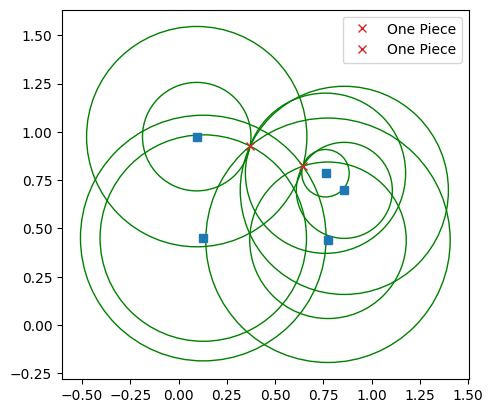

In [9]:
plot_scenario(robots_pos, targets_pos_real, est_targets_dists)
plt.show()

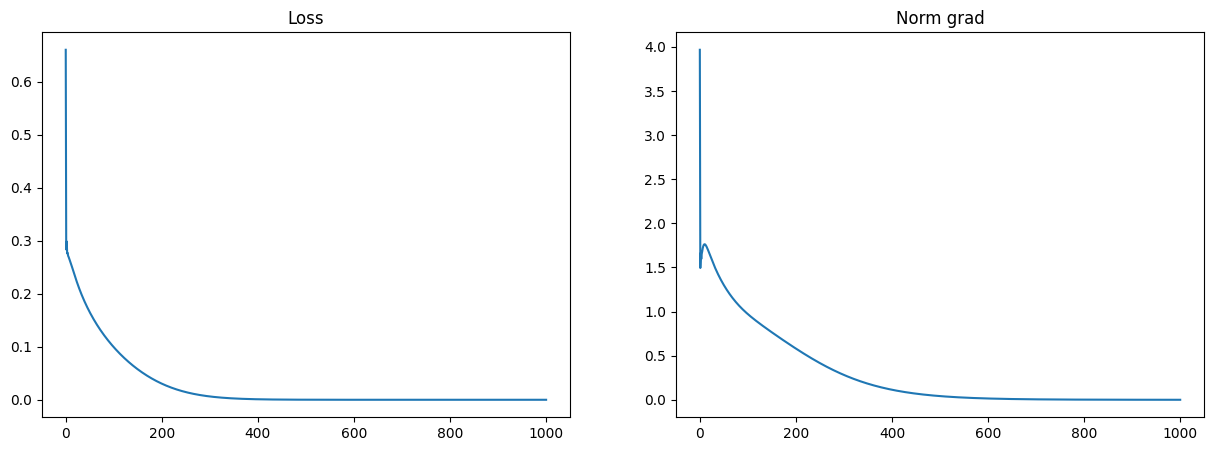

In [10]:
history_z = gradient_tracking(
    fn_list = loss_fns,
    z0 = z0.copy(),
    A = A,
    num_iters = 1000,
    alpha = 2e-2,
)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(
    range(len(history_z)),
    [ sum(loss_fns[i](z[i].flatten()) for i in range(NUM_ROBOTS)) for z in history_z ]
)

plt.subplot(1, 2, 2)
plt.title("Norm grad")
plt.plot(
    range(len(history_z)),
    [ sum(np.linalg.norm(loss_fns[i].grad(z[i].flatten())) for i in range(NUM_ROBOTS)) for z in history_z ]
)

plt.show()

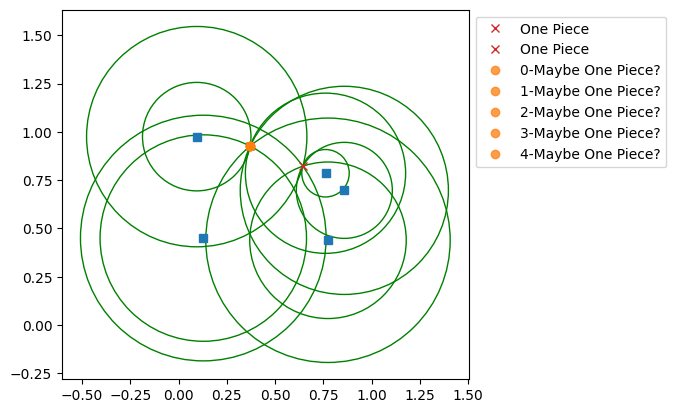

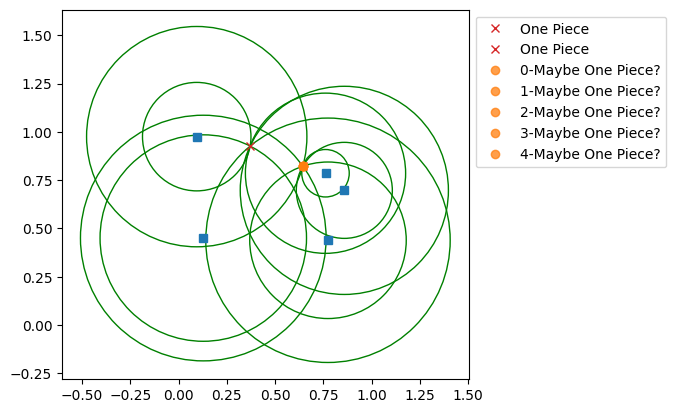

In [11]:
for i in range(NUM_TARGETS):
    plot_scenario(robots_pos, targets_pos_real, est_targets_dists, history_z[-1].reshape(NUM_ROBOTS, NUM_TARGETS, VARS_DIM)[:, i:i+1])
    plt.show()

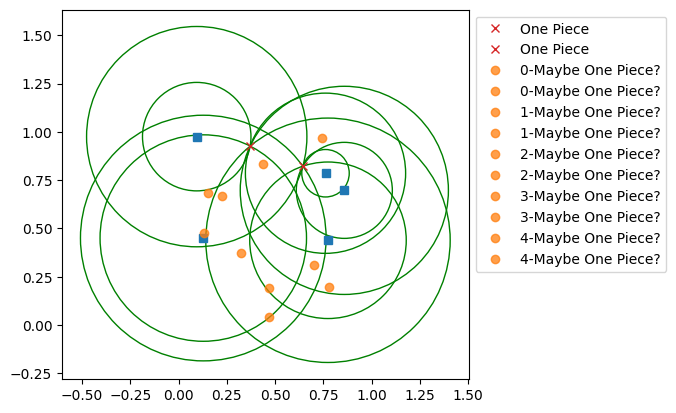

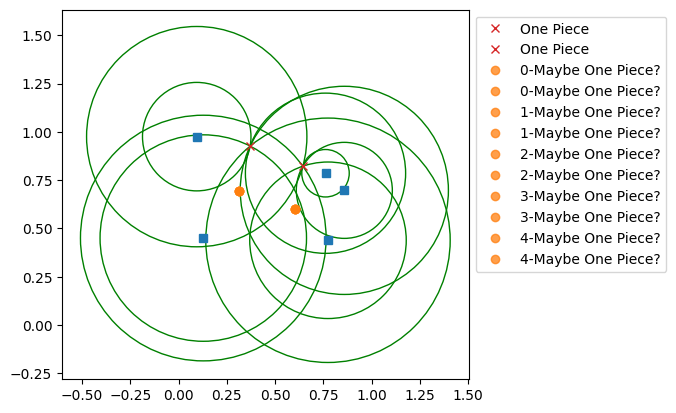

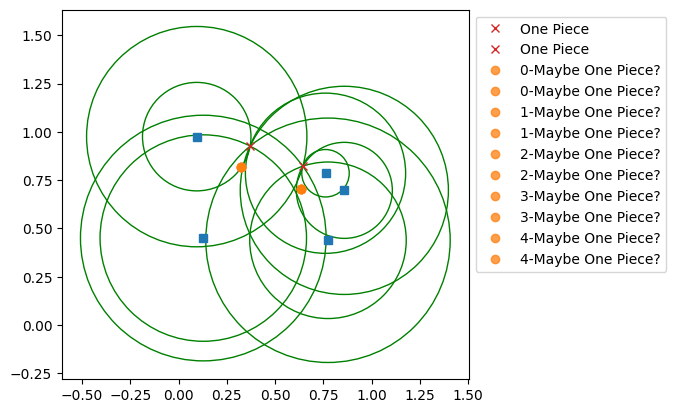

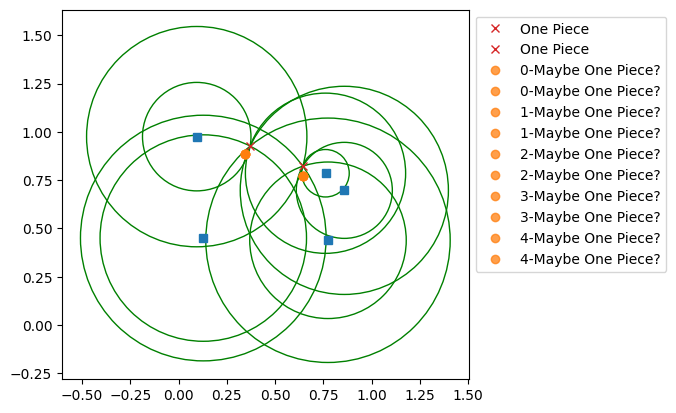

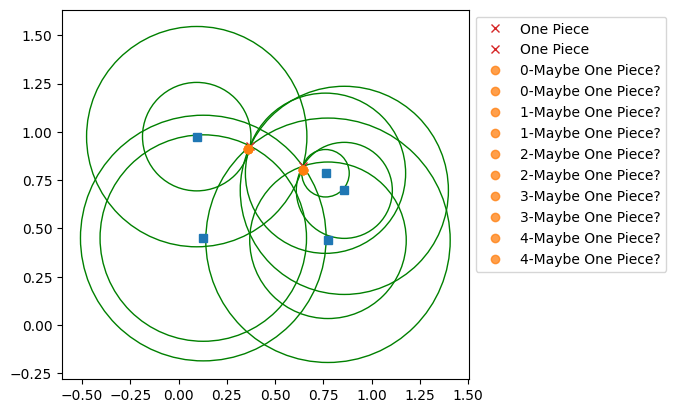

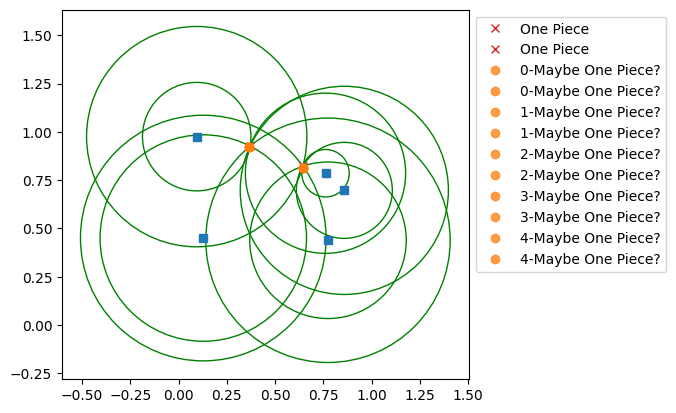

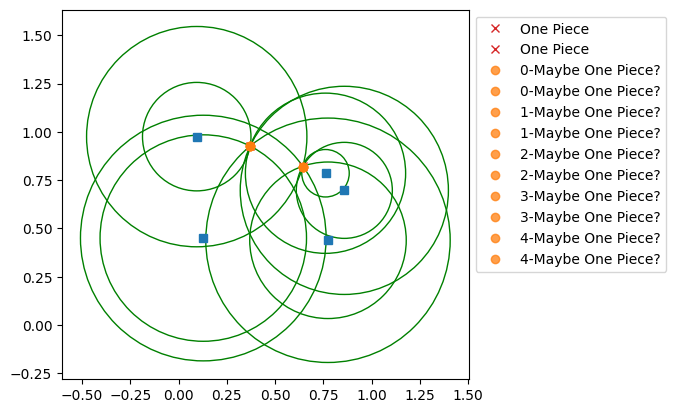

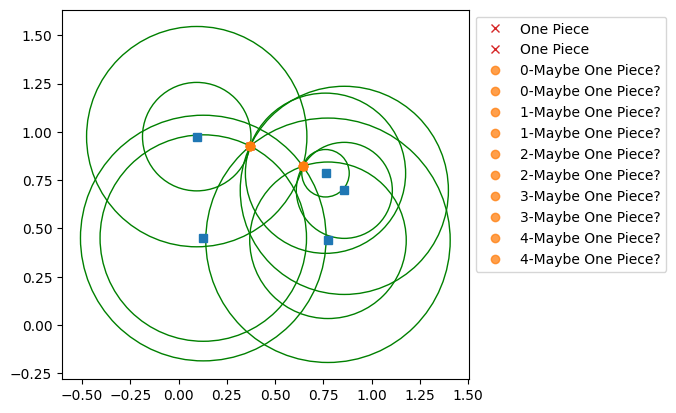

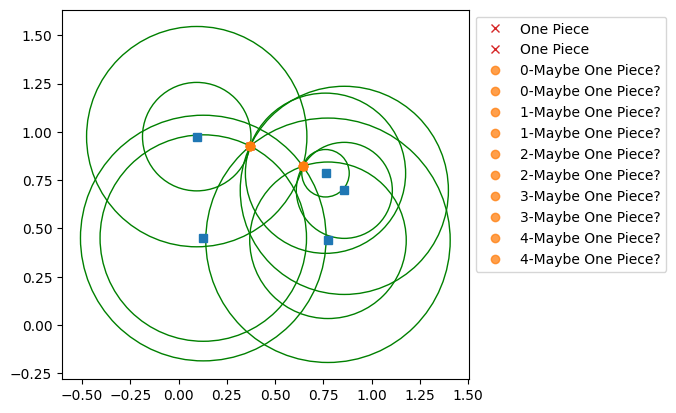

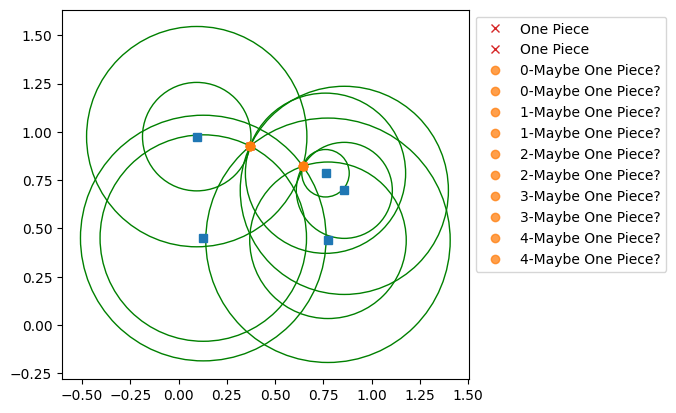

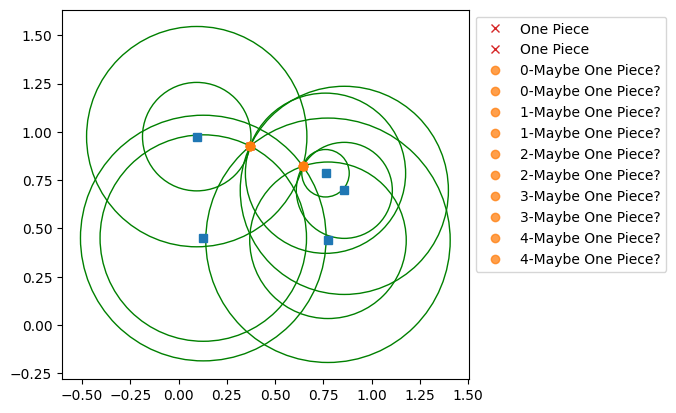

In [12]:
for i in range(0, len(history_z), 100):
    plot_scenario(robots_pos, targets_pos_real, est_targets_dists, history_z[i].reshape(NUM_ROBOTS, NUM_TARGETS, VARS_DIM))
    plt.show()